In [1]:
# Import Libraries
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
import scipy
from arango import ArangoClient

In [2]:
def load_graph_from_processed_data(processed_data_folder):
    """
    Load processed data (nodes and edges) into a NetworkX graph.
    """
    G = nx.Graph()

    # Load nodes first (if node files exist)
    for file in os.listdir(processed_data_folder):
        if file.endswith("_nodes.csv"):
            nodes_file = os.path.join(processed_data_folder, file)
            try:
                nodes_df = pd.read_csv(nodes_file)
                for _, row in nodes_df.iterrows():
                    node_id = row.get("node_id")  # Adjust column name as needed
                    if node_id:
                        G.add_node(node_id, **row.to_dict())
            except Exception as e:
                print(f"Error processing node file '{file}': {e}")

    # Load edges
    for file in os.listdir(processed_data_folder):
        if file.endswith("_edges.csv"):
            edges_file = os.path.join(processed_data_folder, file)
            try:
                edges_df = pd.read_csv(edges_file)

                # Identify correct column names
                column_pairs = [
                    ("authors", "source_domain"),
                    ("Alleged deployer of AI system", "Alleged developer of AI system"),
                    ("Known AI Goal", "Known AI Technology"),
                    ("duplicate_incident_number", "true_incident_number")
                ]
                
                source_col, target_col = None, None
                for col1, col2 in column_pairs:
                    if col1 in edges_df.columns and col2 in edges_df.columns:
                        source_col, target_col = col1, col2
                        break
                
                if not source_col or not target_col:
                    print(f"Skipping file '{file}': No matching column structure.")
                    continue

                # Add edges while preventing duplicates
                seen_edges = set()
                for _, row in edges_df.iterrows():
                    source = row[source_col]
                    target = row[target_col]
                    weight = row.get("weight", 1)

                    # Check for duplicates in both directions
                    if (source, target) not in seen_edges and (target, source) not in seen_edges:
                        G.add_edge(source, target, weight=weight)
                        seen_edges.add((source, target))

            except Exception as e:
                print(f"Error processing edge file '{file}': {e}")
                continue

    return G

In [3]:
# Path to the processed data folder
processed_data_folder = "/Users/sylvesterduah/Documents/Code/De_Alignment/data/processed/"

# Load the graph
G = load_graph_from_processed_data(processed_data_folder)

# Print basic graph information
print("Graph Info:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Nodes: {list(G.nodes)[:5]}")  # Print first 5 nodes
print(f"Edges: {list(G.edges)[:5]}")  # Print first 5 edges

Graph Info:
Number of nodes: 5730
Number of edges: 4398
Nodes: ['Content Recommendation, Content Search, Hate Speech Detection, NSFW Content Detection', 'Content-based Filtering, Collaborative Filtering', 'Hate Speech Detection', 'Character NGrams', 'Autonomous Driving']
Edges: [('Content Recommendation, Content Search, Hate Speech Detection, NSFW Content Detection', 'Content-based Filtering, Collaborative Filtering'), ('Content-based Filtering, Collaborative Filtering', 'Content Recommendation'), ('Hate Speech Detection', 'Character NGrams'), ('Hate Speech Detection', 'Classification, Distributional Learning'), ('Hate Speech Detection', nan)]


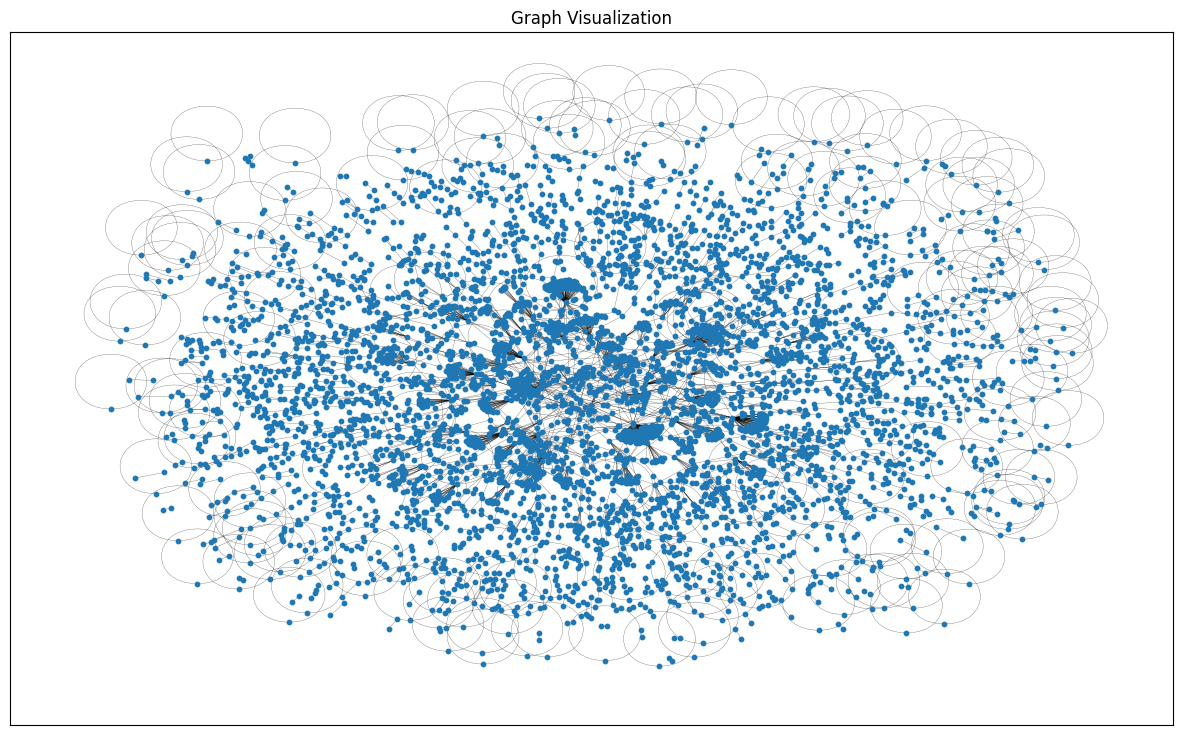

Graph saved to 'graph.graphml'.


In [4]:
# Visualize the graph
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)
plt.title("Graph Visualization")
plt.show()

# Save the graph
nx.write_graphml(G, "graph.graphml")
print("Graph saved to 'graph.graphml'.")

In [5]:
# Validate the graph
print("Validating graph...")
if G.number_of_nodes() == 0:
    print("Error: No nodes found in the graph.")
if G.number_of_edges() == 0:
    print("Error: No edges found in the graph.")
isolated_nodes = list(nx.isolates(G))
if isolated_nodes:
    print(f"Warning: {len(isolated_nodes)} isolated nodes found.")
self_loops = list(nx.selfloop_edges(G))
if self_loops:
    print(f"Warning: {len(self_loops)} self-loops found.")

Validating graph...


In [6]:
from arango import ArangoClient

# Initialize the ArangoDB client
client = ArangoClient(hosts="http://localhost:8529")

# Connect to the _system database for administrative tasks
sys_db = client.db("_system", username="root", password="newpassword")

# First create the database if it doesn't exist using the _system database
if not sys_db.has_database("graph_db"):
    sys_db.create_database("graph_db")
    print("Database 'graph_db' created successfully")

# Now connect to the newly created (or existing) database
db = client.db("graph_db", username="root", password="newpassword")

# Then create or get the graph
if not db.has_graph("ai_incidents_graph"):
    graph = db.create_graph("ai_incidents_graph")
else:
    graph = db.graph("ai_incidents_graph")

# Create vertex collection
if not graph.has_vertex_collection("nodes"):
    nodes_collection = graph.create_vertex_collection("nodes")
else:
    nodes_collection = graph.vertex_collection("nodes")

# Create edge definition
if not graph.has_edge_definition("edges"):
    edges_collection = graph.create_edge_definition(
        edge_collection="edges",
        from_vertex_collections=["nodes"],
        to_vertex_collections=["nodes"]
    )
else:
    edges_collection = graph.edge_collection("edges")

print("Setup completed successfully!")

Setup completed successfully!


In [7]:
from arango import ArangoClient
import networkx as nx
import re
from uuid import uuid4

# Step 1: Set up ArangoDB connection
def setup_arangodb_connection(db_name="graph_db", graph_name="ai_incidents_graph"):
    """
    Set up the ArangoDB connection and create the graph and collections if they don't exist.
    """
    client = ArangoClient(hosts="http://localhost:8529")  # Replace with ArangoGraph URL if using the cloud version
    db = client.db(db_name, username="root", password="newpassword")

    # Create the graph if it doesn't exist
    if not db.has_graph(graph_name):
        graph = db.create_graph(graph_name)
    else:
        graph = db.graph(graph_name)

    # Create collections for nodes and edges if they don't exist
    nodes_collection_name = "nodes"
    edges_collection_name = "edges"

    if not graph.has_vertex_collection(nodes_collection_name):
        nodes_collection = graph.create_vertex_collection(nodes_collection_name)
    else:
        nodes_collection = graph.vertex_collection(nodes_collection_name)

    if not graph.has_edge_definition(edges_collection_name):
        edges_collection = graph.create_edge_definition(
            edge_collection=edges_collection_name,
            from_vertex_collections=[nodes_collection_name],
            to_vertex_collections=[nodes_collection_name]
        )
    else:
        edges_collection = graph.edge_collection(edges_collection_name)

    return db, graph, nodes_collection, edges_collection

# Step 2: Sanitize node keys
def sanitize_key(key):
    """
    Sanitize a key to make it valid for ArangoDB.
    """
    # Replace invalid characters with underscores
    sanitized_key = re.sub(r"[^a-zA-Z0-9_\-:]", "_", str(key))
    # Ensure the key is not empty
    if not sanitized_key:
        sanitized_key = "default_key"
    # Truncate to 254 characters
    return sanitized_key[:254]

# Step 3: Persist the NetworkX graph to ArangoDB
def persist_graph_to_arangodb(G, nodes_collection, edges_collection):
    """
    Persist a NetworkX graph to ArangoDB.
    """
    # Track sanitized keys to handle duplicates
    key_mapping = {}

    # Add nodes to ArangoDB
    for node, data in G.nodes(data=True):
        sanitized_key = sanitize_key(node)
        if sanitized_key in key_mapping:
            # Append a UUID to handle duplicates
            sanitized_key = f"{sanitized_key}_{uuid4().hex[:8]}"  # Use first 8 characters of UUID
        key_mapping[node] = sanitized_key

        # Check if the node already exists in ArangoDB
        if not nodes_collection.has(sanitized_key):
            nodes_collection.insert({"_key": sanitized_key, **data})
        else:
            print(f"Node '{sanitized_key}' already exists. Skipping insertion.")

    # Add edges to ArangoDB
    for source, target, data in G.edges(data=True):
        sanitized_source = key_mapping[source]
        sanitized_target = key_mapping[target]
        edges_collection.insert({
            "_from": f"nodes/{sanitized_source}",
            "_to": f"nodes/{sanitized_target}",
            **data
        })

# Step 4: Validate the graph in ArangoDB
def validate_graph_in_arangodb(nodes_collection, edges_collection):
    """
    Validate the graph in ArangoDB by checking node and edge counts.
    """
    # Validate node count
    node_count = nodes_collection.count()
    print(f"Number of nodes in ArangoDB: {node_count}")

    # Validate edge count
    edge_count = edges_collection.count()
    print(f"Number of edges in ArangoDB: {edge_count}")

    # Validate a specific node
    sample_node_key = nodes_collection.all(limit=1).next()["_key"]
    node = nodes_collection.get(sample_node_key)
    print(f"Sample node '{sample_node_key}': {node}")

    # Validate a specific edge
    sample_edge = edges_collection.all(limit=1).next()
    print(f"Sample edge: {sample_edge}")

# Step 5: Main workflow
def main():
    # Step 1: Set up ArangoDB connection
    db, graph, nodes_collection, edges_collection = setup_arangodb_connection()

    # Step 2: Load your NetworkX graph from GraphML
    graphml_file = "graph.graphml"  # Replace with the path to your GraphML file
    G = nx.read_graphml(graphml_file)

    # Step 3: Persist the NetworkX graph to ArangoDB
    persist_graph_to_arangodb(G, nodes_collection, edges_collection)
    print("Graph persisted to ArangoDB.")

    # Step 4: Validate the graph in ArangoDB
    validate_graph_in_arangodb(nodes_collection, edges_collection)

# Run the main workflow
if __name__ == "__main__":
    main()

Node 'Content_Recommendation__Content_Search__Hate_Speech_Detection__NSFW_Content_Detection' already exists. Skipping insertion.
Node 'Content-based_Filtering__Collaborative_Filtering' already exists. Skipping insertion.
Node 'Hate_Speech_Detection' already exists. Skipping insertion.
Node 'Character_NGrams' already exists. Skipping insertion.
Node 'Autonomous_Driving' already exists. Skipping insertion.
Node 'nan' already exists. Skipping insertion.
Node 'AI_Voice_Assistant' already exists. Skipping insertion.
Node 'Automatic_Speech_Recognition__Language_Modeling__Acoustic_Fingerprint' already exists. Skipping insertion.
Node 'Face_Recognition' already exists. Skipping insertion.
Node 'Deepfake_Video_Generation' already exists. Skipping insertion.
Node 'Neural_Network__Face_Detection__Recurrent_Neural_Network__Generative_Adversarial_Network' already exists. Skipping insertion.
Node 'Substance_Detection__Smart_Devices' already exists. Skipping insertion.
Node 'Gesture_Recognition' alre

In [8]:
from arango import ArangoClient
import networkx as nx

# Step 1: Set up ArangoDB connection
def setup_arangodb_connection(db_name="graph_db", graph_name="ai_incidents_graph"):
    """
    Set up the ArangoDB connection and create the graph and collections if they don't exist.
    """
    client = ArangoClient(hosts="http://localhost:8529") 
    db = client.db(db_name, username="root", password="newpassword")

    # Create the graph if it doesn't exist
    if not db.has_graph(graph_name):
        graph = db.create_graph(graph_name)
    else:
        graph = db.graph(graph_name)

    # Create collections for nodes and edges if they don't exist
    nodes_collection_name = "nodes"
    edges_collection_name = "edges"

    if not graph.has_vertex_collection(nodes_collection_name):
        nodes_collection = graph.create_vertex_collection(nodes_collection_name)
    else:
        nodes_collection = graph.vertex_collection(nodes_collection_name)

    if not graph.has_edge_definition(edges_collection_name):
        edges_collection = graph.create_edge_definition(
            edge_collection=edges_collection_name,
            from_vertex_collections=[nodes_collection_name],
            to_vertex_collections=[nodes_collection_name]
        )
    else:
        edges_collection = graph.edge_collection(edges_collection_name)

    return db, graph, nodes_collection, edges_collection

# Step 2: Create an ArangoDB-backed NetworkX graph
def create_arangodb_backed_graph(db, graph_name="ai_incidents_graph"):
    """
    Create an ArangoDB-backed NetworkX graph.
    """
    # Check if the graph exists in ArangoDB
    if not db.has_graph(graph_name):
        raise ValueError(f"Graph '{graph_name}' does not exist in ArangoDB.")

    # Get the graph and collections
    graph = db.graph(graph_name)
    nodes_collection = graph.vertex_collection("nodes")
    edges_collection = graph.edge_collection("edges")

    # Create a NetworkX graph backed by ArangoDB
    G = nx.Graph()

    # Add nodes from ArangoDB
    for node in nodes_collection.all():
        G.add_node(node["_key"], **node)

    # Add edges from ArangoDB
    for edge in edges_collection.all():
        source = edge["_from"].split("/")[1]  # Extract node key from "_from"
        target = edge["_to"].split("/")[1]    # Extract node key from "_to"
        G.add_edge(source, target, **edge)

    return G

# Step 3: Main workflow
def main():
    # Step 1: Set up ArangoDB connection
    db, graph, nodes_collection, edges_collection = setup_arangodb_connection()

    # Step 2: Create an ArangoDB-backed NetworkX graph
    G = create_arangodb_backed_graph(db, graph_name="ai_incidents_graph")

    # Step 3: Print the graph info
    print("ArangoDB-backed NetworkX Graph:")
    print(G)

    # Step 4: Print basic graph information
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Nodes: {list(G.nodes)[:5]}")  # Print first 5 nodes
    print(f"Edges: {list(G.edges)[:5]}")  # Print first 5 edges

# Run the main workflow
if __name__ == "__main__":
    main()

ArangoDB-backed NetworkX Graph:
Graph with 5725 nodes and 4398 edges
Number of nodes: 5725
Number of edges: 4398
Nodes: ['Content_Recommendation__Content_Search__Hate_Speech_Detection__NSFW_Content_Detection', 'Content-based_Filtering__Collaborative_Filtering', 'Hate_Speech_Detection', 'Character_NGrams', 'Autonomous_Driving']
Edges: [('Content_Recommendation__Content_Search__Hate_Speech_Detection__NSFW_Content_Detection', 'Content-based_Filtering__Collaborative_Filtering'), ('Content-based_Filtering__Collaborative_Filtering', 'Content_Recommendation'), ('Hate_Speech_Detection', 'Character_NGrams'), ('Hate_Speech_Detection', 'Classification__Distributional_Learning'), ('Hate_Speech_Detection', 'nan')]


In [9]:
G.degree(107)

1

In [10]:
# Step 4: Query the Graph
def query_graph(db, graph_name="ai_incidents_graph"):
    """
    Query the graph in ArangoDB with additional attributes and complex traversals.
    """
    # Get the graph and collections
    graph = db.graph(graph_name)
    nodes_collection = graph.vertex_collection("nodes")
    edges_collection = graph.edge_collection("edges")

    # Sample 3 nodes
    result = db.aql.execute("""
        FOR node IN nodes
            SORT RAND()
            LIMIT 3
            RETURN node
    """)
    print("Sample 3 nodes:")
    print(list(result))
    print('-' * 10)

    # Sample 3 edges
    result = db.aql.execute("""
        FOR edge IN edges
            SORT RAND()
            LIMIT 3
            RETURN edge
    """)
    print("Sample 3 edges:")
    print(list(result))
    print('-' * 10)

    # Traverse a node's 1-hop neighborhood
    node_key = "Content_Recommendation__Content_Search__Hate_Speech_Detection__NSFW_Content_Detection_0"
    result = db.aql.execute(f"""
        FOR v, e, p IN 1..1 ANY 'nodes/{node_key}' GRAPH ai_incidents_graph
            LIMIT 1
            RETURN p
    """)
    print(f"1-hop neighborhood of node '{node_key}':")
    print(list(result))
    print('-' * 10)

    # Query all nodes with a specific attribute
    result = db.aql.execute("""
        FOR node IN nodes
            FILTER node.type == "AI System"
            LIMIT 3
            RETURN node
    """)
    print("Nodes with type 'AI System':")
    print(list(result))
    print('-' * 10)

    # Query all edges with a specific attribute
    result = db.aql.execute("""
        FOR edge IN edges
            FILTER edge.weight > 1
            LIMIT 3
            RETURN edge
    """)
    print("Edges with weight > 1:")
    print(list(result))
    print('-' * 10)

    # Query the degree of a specific node
    result = db.aql.execute(f"""
        LET node_id = 'nodes/{node_key}'
        RETURN LENGTH(
            FOR edge IN edges
                FILTER edge._from == node_id OR edge._to == node_id
                RETURN edge
        )
    """)
    print(f"Degree of node '{node_key}':")
    print(list(result))
    print('-' * 10)

    # Query the shortest path between two nodes
    start_node_key = "Content_Recommendation__Content_Search__Hate_Speech_Detection__NSFW_Content_Detection_0"
    end_node_key = "Autonomous_Driving_4"
    result = db.aql.execute(f"""
        FOR v, e IN OUTBOUND SHORTEST_PATH 'nodes/{start_node_key}' TO 'nodes/{end_node_key}' GRAPH ai_incidents_graph
            RETURN {{ "vertices": v, "edges": e }}
    """)
    print(f"Shortest path from '{start_node_key}' to '{end_node_key}':")
    print(list(result))
    print('-' * 10)

    # Query nodes with multiple attributes
    result = db.aql.execute("""
        FOR node IN nodes
            FILTER node.type == "AI System" AND node.attribute2 == "value2"
            LIMIT 3
            RETURN node
    """)
    print("Nodes with type 'AI System' and attribute2 == 'value2':")
    print(list(result))
    print('-' * 10)

    # Query edges with multiple attributes
    result = db.aql.execute("""
        FOR edge IN edges
            FILTER edge.weight > 1 AND edge.attribute2 == "value2"
            LIMIT 3
            RETURN edge
    """)
    print("Edges with weight > 1 and attribute2 == 'value2':")
    print(list(result))
    print('-' * 10)

    # Query nodes with a specific attribute and sort by another attribute
    result = db.aql.execute("""
        FOR node IN nodes
            FILTER node.type == "AI System"
            SORT node.attribute3 DESC
            LIMIT 3
            RETURN node
    """)
    print("Nodes with type 'AI System', sorted by attribute3 (descending):")
    print(list(result))
    print('-' * 10)

    # Query the 2-hop neighborhood of a node
    result = db.aql.execute(f"""
        FOR v, e, p IN 1..2 ANY 'nodes/{node_key}' GRAPH ai_incidents_graph
            LIMIT 3
            RETURN p
    """)
    print(f"2-hop neighborhood of node '{node_key}':")
    print(list(result))
    print('-' * 10)

    # Query all paths between two nodes with a maximum depth of 3
    result = db.aql.execute(f"""
        FOR v, e, p IN 1..3 ANY 'nodes/{start_node_key}' GRAPH ai_incidents_graph
            FILTER v._key == '{end_node_key}'
            LIMIT 3
            RETURN p
    """)
    print(f"All paths (max depth 3) from '{start_node_key}' to '{end_node_key}':")
    print(list(result))
    print('-' * 10)

    # Query nodes with the highest degree
    result = db.aql.execute("""
        FOR node IN nodes
            LET degree = LENGTH(
                FOR edge IN edges
                    FILTER edge._from == node._id OR edge._to == node._id
                    RETURN edge
            )
            SORT degree DESC
            LIMIT 3
            RETURN { "node": node, "degree": degree }
    """)
    print("Nodes with the highest degree:")
    print(list(result))
    print('-' * 10)

    # Query nodes with no edges (isolated nodes)
    result = db.aql.execute("""
        FOR node IN nodes
            FILTER LENGTH(
                FOR edge IN edges
                    FILTER edge._from == node._id OR edge._to == node._id
                    RETURN edge
            ) == 0
            LIMIT 3
            RETURN node
    """)
    print("Isolated nodes (no edges):")
    print(list(result))
    print('-' * 10)

# Step 5: Main workflow
def main():
    # Step 1: Set up ArangoDB connection
    db, graph, nodes_collection, edges_collection = setup_arangodb_connection()

    # Step 2: Query the graph
    query_graph(db, graph_name="ai_incidents_graph")

# Run the main workflow
if __name__ == "__main__":
    main()

Sample 3 nodes:
[{'_key': 'Gunshot_Detection__Predictive_Policing', '_id': 'nodes/Gunshot_Detection__Predictive_Policing', '_rev': '_jSThxgq---'}, {'_key': '__Neil_Perry___Megha_Srivastava___Deepak_Kumar___Dan_Boneh__', '_id': 'nodes/__Neil_Perry___Megha_Srivastava___Deepak_Kumar___Dan_Boneh__', '_rev': '_jSTi-Ze---'}, {'_key': '__Joseph_Pisani___Victoria_Albert__', '_id': 'nodes/__Joseph_Pisani___Victoria_Albert__', '_rev': '_jSTiAA2---'}]
----------
Sample 3 edges:
[{'_key': '84356', '_id': 'edges/84356', '_from': 'nodes/benzinga_com', '_to': 'nodes/__Ananya_Gairola__', '_rev': '_jSWLIeu---', 'weight': 1}, {'_key': '74297', '_id': 'edges/74297', '_from': 'nodes/__spamouflage-dragon__', '_to': 'nodes/__synthesia__', '_rev': '_jSWLELe---', 'weight': 1}, {'_key': '141189', '_id': 'edges/141189', '_from': 'nodes/themarkup_org', '_to': 'nodes/__Leon_Yin___Adrianne_Jeffries___Surya_Mattu__', '_rev': '_jSlCKMK---', 'weight': 1}]
----------
1-hop neighborhood of node 'Content_Recommendation_

In [11]:
# Path to the processed data folder
processed_data_folder = "/Users/sylvesterduah/Documents/Code/De_Alignment/data/processed/"

# Load the graph
G = load_graph_from_processed_data(processed_data_folder)

# Print basic graph information
print("Graph Info:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Nodes: {list(G.nodes)[:5]}")  # Print first 5 nodes
print(f"Edges: {list(G.edges)[:5]}")  # Print first 5 edges

Graph Info:
Number of nodes: 5730
Number of edges: 4398
Nodes: ['Content Recommendation, Content Search, Hate Speech Detection, NSFW Content Detection', 'Content-based Filtering, Collaborative Filtering', 'Hate Speech Detection', 'Character NGrams', 'Autonomous Driving']
Edges: [('Content Recommendation, Content Search, Hate Speech Detection, NSFW Content Detection', 'Content-based Filtering, Collaborative Filtering'), ('Content-based Filtering, Collaborative Filtering', 'Content Recommendation'), ('Hate Speech Detection', 'Character NGrams'), ('Hate Speech Detection', 'Classification, Distributional Learning'), ('Hate Speech Detection', nan)]


In [35]:
from langchain_community.graphs import ArangoGraph
from arango import ArangoClient
from arango.exceptions import ArangoClientError, ArangoServerError
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def setup_arangodb_connection(db_name="graph_db", graph_name="ai_incidents_graph"):
    """Set up the ArangoDB connection and create the graph and collections if they don't exist."""
    try:
        # Initialize ArangoDB client
        client = ArangoClient(hosts="http://localhost:8529")

        # Connect to _system database for admin operations
        sys_db = client.db("_system", username="root", password="newpassword")
        
        # Create database if it doesn't exist
        if not sys_db.has_database(db_name):
            sys_db.create_database(db_name)
            logger.info("Created new database: %s", db_name)
        
        # Connect to target database
        db = client.db(db_name, username="root", password="newpassword")
        logger.info("Connected to database: %s", db_name)

        # Create graph if it doesn't exist
        if not db.has_graph(graph_name):
            graph = db.create_graph(graph_name)
            logger.info("Created new graph: %s", graph_name)
        else:
            graph = db.graph(graph_name)
            logger.info("Using existing graph: %s", graph_name)

         # Create collections with proper names
        nodes_collection_name = "ai_nodes"  # Changed from "nodes"
        edges_collection_name = "ai_edges"  # Changed from "edges"

        if not graph.has_vertex_collection(nodes_collection_name):
            nodes_collection = graph.create_vertex_collection(nodes_collection_name)
            logger.info("Created vertex collection: %s", nodes_collection_name)
        else:
            nodes_collection = graph.vertex_collection(nodes_collection_name)
            logger.info("Found existing vertex collection: %s", nodes_collection_name)

        if not graph.has_edge_definition(edges_collection_name):
            edges_collection = graph.create_edge_definition(
                edge_collection=edges_collection_name,
                from_vertex_collections=[nodes_collection_name],
                to_vertex_collections=[nodes_collection_name]
            )
            logger.info("Created edge collection: %s", edges_collection_name)
        else:
            edges_collection = graph.edge_collection(edges_collection_name)
            logger.info("Found existing edge collection: %s", edges_collection_name)

        return db, graph, nodes_collection, edges_collection

    except ArangoClientError as e:
        logger.error("Connection error: %s", str(e))
        raise
    except ArangoServerError as e:
        logger.error("Server error: %s", str(e))
        raise
    except Exception as e:
        logger.error("Unexpected error: %s", str(e))
        raise

def create_arangograph_wrapper(db):
    """Create ArangoGraph LangChain wrapper with validation"""
    try:
        if not db:
            raise ValueError("Database connection is invalid")
        
        arango_graph = ArangoGraph(db)
        logger.info("ArangoGraph wrapper created successfully")
        return arango_graph
    except Exception as e:
        logger.error("Wrapper creation failed: %s", str(e))
        raise

def main():
    try:
        # Setup database connection
        db, graph, nodes_coll, edges_coll = setup_arangodb_connection()
        
        # Create LangChain wrapper
        arango_graph = create_arangograph_wrapper(db)
        
        # Add test data (optional)
        nodes_coll.insert({"_key": "test_node", "type": "example"})
        edges_coll.insert({
            "_from": "nodes/test_node",
            "_to": "nodes/test_node",
            "type": "example_relation"
        })
        
        # Query data with proper AQL syntax
        num_nodes = arango_graph.query("RETURN LENGTH(nodes)")
        num_edges = arango_graph.query("RETURN LENGTH(edges)")
        
        # Better practice: Use COLLECTION_COUNT
        node_count = arango_graph.query("RETURN COLLECTION_COUNT('nodes')")[0]
        edge_count = arango_graph.query("RETURN COLLECTION_COUNT('edges')")[0]
        
        print(f"Nodes: {node_count}, Edges: {edge_count}")

    except Exception as e:
        logger.error("Main workflow error: %s", str(e))

if __name__ == "__main__":
    main()

INFO:__main__:Connected to database: graph_db
INFO:__main__:Using existing graph: ai_incidents_graph
INFO:__main__:Created vertex collection: ai_nodes
INFO:__main__:Created edge collection: ai_edges
INFO:__main__:ArangoGraph wrapper created successfully


Nodes: 5726, Edges: 21991


In [36]:
from typing import List, Dict, Optional

class ExtendedArangoGraph(ArangoGraph):
    """
    Extended ArangoGraph wrapper with additional functionality.
    """

    def get_nodes(self, limit: int = 10) -> List[Dict]:
        """
        Query nodes from the graph.
        """
        query = f"""
            FOR node IN nodes
                LIMIT {limit}
                RETURN node
        """
        result = self.query(query)
        return list(result)

    def get_edges(self, limit: int = 10) -> List[Dict]:
        """
        Query edges from the graph.
        """
        query = f"""
            FOR edge IN edges
                LIMIT {limit}
                RETURN edge
        """
        result = self.query(query)
        return list(result)

    def get_node_by_key(self, node_key: str) -> Optional[Dict]:
        """
        Query a node by its key.
        """
        query = f"""
            FOR node IN nodes
                FILTER node._key == '{node_key}'
                RETURN node
        """
        result = self.query(query)
        return result[0] if result else None

    def get_neighbors(self, node_key: str, depth: int = 1) -> List[Dict]:
        """
        Query the neighbors of a node up to a specified depth.
        """
        query = f"""
            FOR v, e, p IN 1..{depth} ANY 'nodes/{node_key}' GRAPH ai_incidents_graph
                RETURN v
        """
        result = self.query(query)
        return list(result)

    def insert_node(self, node: Dict) -> bool:
        """
        Insert a node into the graph.
        """
        query = """
            INSERT @node INTO nodes
            RETURN NEW
        """
        result = self.query(query, bind_vars={"node": node})
        return bool(result)

    def insert_edge(self, edge: Dict) -> bool:
        """
        Insert an edge into the graph.
        """
        query = """
            INSERT @edge INTO edges
            RETURN NEW
        """
        result = self.query(query, bind_vars={"edge": edge})
        return bool(result)

    def delete_node(self, node_key: str) -> bool:
        """
        Delete a node from the graph.
        """
        query = f"""
            REMOVE {{ _key: '{node_key}' }} IN nodes
            RETURN OLD
        """
        result = self.query(query)
        return bool(result)

    def delete_edge(self, edge_key: str) -> bool:
        """
        Delete an edge from the graph.
        """
        query = f"""
            REMOVE {{ _key: '{edge_key}' }} IN edges
            RETURN OLD
        """
        result = self.query(query)
        return bool(result)

In [58]:
import getpass
import os

os.environ["GROQ_API_KEY"] = "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"

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain.chat_models import init_chat_model

model = init_chat_model("llama3-8b-8192", model_provider="groq")

In [61]:
from langchain.agents import tool  # <-- Add this import
from langchain_groq import ChatGroq
from langchain.chains import ArangoGraphQAChain

@tool  # Now properly imported
def text_to_aql_to_text(query: str):
    """This tool invokes the ArangoGraphQAChain with Groq's LLM to:
    1. Translate natural language to AQL
    2. Execute the query
    3. Translate results back to natural language
    """
    
    # Initialize Groq chat model
    llm = ChatGroq(
        temperature=0,
        model_name="llama3-8b-8192",  # Using your preferred model
        groq_api_key=os.environ["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"]
    )
    
    # Create QA chain
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True
    )
    
    # Execute the chain
    result = chain.invoke({"query": query})
    
    return str(result["result"])

In [20]:
from langchain.agents import tool
from langchain_groq import ChatGroq
import re
import networkx as nx
import os

# Modified tool using Groq and your existing graph structure
@tool
def text_to_nx_algorithm_to_text(query: str):
    """Executes complex NetworkX analysis on ArangoDB graph data. Use for algorithms like centrality, community detection, or path finding that require full graph analysis."""
    
    # Initialize Groq chat model
    llm = ChatGroq(
        temperature=0,
        model_name="llama3-8b-8192",
        groq_api_key=os.environ["GROQ_API_KEY"]
    )

    # Get sample node/edge structure for LLM context
    sample_node = next(iter(G.nodes(data=True)))[1] if G.nodes else {}
    sample_edge = next(iter(G.edges(data=True)))[2] if G.edges else {}


    # Generate NetworkX code
    text_to_nx = llm.invoke(f"""
    NetworkX Graph Structure:
    - Node format: (ID, {sample_node})
    - Edge format: (Source, Target, {sample_edge})
    
    Query: {query}
    
    Generate Python code using NetworkX that:
    1. Answers the query using appropriate algorithms
    2. Stores result in FINAL_RESULT
    3. Uses the graph variable 'G'
    4. Returns concise output
    
    Code-only response in ```python:
    """).content

    # Clean and validate code
    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
    if "FINAL_RESULT" not in text_to_nx_cleaned:
        return "Error: Generated code missing FINAL_RESULT variable"

    # Execute generated code
    try:
        local_vars = {"G": G, "nx": nx}
        exec(text_to_nx_cleaned, {}, local_vars)
        result = local_vars["FINAL_RESULT"]
    except Exception as e:
        return f"Execution Error: {str(e)}"

    # Format final answer
    return llm.invoke(f"""
    Query: {query}
    Analysis Result: {result}
    Convert this technical result into a natural language answer focusing on AI incident relationships:
    """).content

# Modified main workflow with tool integration
def main():
    # Setup ArangoDB connection
    db, graph, nodes_coll, edges_coll = setup_arangodb_connection()
    
    # Create NetworkX graph
    G = create_arangodb_backed_graph(db)
    
    # Example usage
    query = "Find the most critical AI incident node using betweenness centrality"
    analysis_result = text_to_nx_algorithm_to_text(query)
    
    print("\nAI Incident Analysis Result:")
    print(analysis_result)

if __name__ == "__main__":
    main()

INFO:__main__:Successfully connected to ArangoDB database: graph_db
INFO:__main__:Using existing graph: ai_incidents_graph
INFO:__main__:Using existing vertex collection: nodes
INFO:__main__:Using existing edge collection: edges
/var/folders/7q/j2lypjp93_x38wr0rthx_ymh0000gn/T/ipykernel_39525/788100212.py:71: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  analysis_result = text_to_nx_algorithm_to_text(query)
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


theguardian.com


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"



AI Incident Analysis Result:
Here's a natural language answer based on the technical result:

"The analysis reveals that the most critical AI incident node is theguardian.com, which plays a crucial role in the network of AI incident relationships. This node is a hub that connects many other nodes, indicating that it is a key player in the spread of AI-related incidents. The betweenness centrality measure highlights theguardian.com's importance in facilitating the flow of information and influencing the behavior of other nodes in the network. In other words, theguardian.com is a critical node that helps to propagate AI incidents and has a significant impact on the overall dynamics of the network."


In [45]:
import os
import re
import operator
import networkx as nx
from typing_extensions import TypedDict
from typing import Annotated, Sequence
from pydantic import BaseModel, Field
from typing import List

from arango import ArangoClient
from langchain.agents import tool
from langchain_groq import ChatGroq
from langchain.chains import ArangoGraphQAChain
from langgraph.graph import StateGraph, END

In [60]:
# 3. NetworkX Graph Creation
def create_networkx_graph(db, graph_name="ai_incidents_graph"):
    """Convert ArangoDB graph to NetworkX"""
    G = nx.Graph()
    graph = db.graph(graph_name)
    
    # Add nodes
    nodes = graph.vertex_collection("ai_nodes").all()
    for node in nodes:
        G.add_node(node["_key"], **node)
    
    # Add edges
    edges = graph.edge_collection("ai_edges").all()
    for edge in edges:
        src = edge["_from"].split("/")[1]
        tgt = edge["_to"].split("/")[1]
        G.add_edge(src, tgt, **edge)
    
    return G

In [74]:
# 4. Define Analysis Tools (updated with Pydantic)
class AITools:
    def __init__(self, db, G):
        self.db = db
        self.G = G
        self.llm = ChatGroq(
            temperature=0,
            model_name="llama3-8b-8192",
            groq_api_key=os.environ["GROQ_API_KEY"]
        )
        self.arango_graph = ArangoGraph(db)

    @tool(args_schema=AgentState)
    def aql_analysis(self, state: AgentState) -> AgentState:
        """Execute AQL-based analysis on AI incidents"""
        chain = ArangoGraphQAChain.from_llm(
            llm=self.llm,
            graph=self.arango_graph,
            verbose=True,
            allow_dangerous_requests=True
        )
        result = chain.invoke({"query": state.input})
        return AgentState(
            input=state.input,
            context=state.context + [f"AQL Analysis: {result['result']}"],
            decision="aql",
            result=result['result']
        )

    @tool(args_schema=AgentState)
    def nx_analysis(self, state: AgentState) -> AgentState:
        """Perform NetworkX graph analysis on AI incidents"""        
        # Generate analysis code
        prompt = f"""AI Incident Graph Analysis Task:
        Graph Schema: Nodes={dict(next(iter(self.G.nodes(data=True)))[1]) if self.G.nodes else {}}
        Query: {state.input}
        Generate Python code using NetworkX to answer this query."""

        code = self.llm.invoke(prompt).content
        cleaned_code = re.sub(r"```python|```", "", code).strip()
        
        # Execute code
        local_vars = {"G": self.G, "nx": nx}
        try:
            exec(cleaned_code, {}, local_vars)
            result = local_vars.get("FINAL_RESULT", "No result generated")
        except Exception as e:
            result = f"Analysis Error: {str(e)}"
        
        return AgentState(
            input=state.input,
            context=state.context + [f"NetworkX Analysis: {result}"],
            decision="nx",
            result=result
        )

    @tool(args_schema=AgentState)
    def hybrid_analysis(self, state: AgentState) -> AgentState:
        """Combine AQL and NetworkX analysis"""
        try:
            aql_state = self.aql_analysis(state)
            if "insufficient" in aql_state.result.lower():
                raise ValueError("Fallback to NetworkX")
            return AgentState(
                input=state.input,
                context=state.context + [f"Hybrid (AQL) Result: {aql_state.result}"],
                decision="hybrid",
                result=aql_state.result
            )
        except:
            nx_state = self.nx_analysis(state)
            return AgentState(
                input=state.input,
                context=state.context + [f"Hybrid (NetworkX) Result: {nx_state.result}"],
                decision="hybrid",
                result=nx_state.result
            )

In [75]:
def create_workflow(tools):
    workflow = StateGraph(AgentState)
    
    # Define nodes (with concrete implementations)
    workflow.add_node(
        "router",
        lambda state: AgentState(**{**state.dict(), 'decision': route_decision(state)})
    )
    workflow.add_node("aql", tools.aql_analysis)
    workflow.add_node("nx", tools.nx_analysis)
    workflow.add_node("hybrid", tools.hybrid_analysis)
    workflow.add_node("format", tools.format_results)

In [76]:
# 6. Main Execution (corrected)
if __name__ == "__main__":
    # Initialize components
    db, graph, nodes_collection, edges_collection = setup_arangodb_connection()
    G = create_networkx_graph(db)
    tools = AITools(db, G)
    agent = create_workflow(tools)

    # Initialize with proper Pydantic model
    initial_state = AgentState(
        input="Analyze connections between recent AI safety incidents in healthcare diagnostics",
        context=[],
        decision="",
        result=""
    )
    
    result = agent.invoke(initial_state)
    
    print("\nAI Incident Analysis Report:")
    print("-" * 40)
    print(result.result)
    print("-" * 40)

INFO:__main__:Connected to database: graph_db
INFO:__main__:Using existing graph: ai_incidents_graph
INFO:__main__:Found existing vertex collection: ai_nodes
INFO:__main__:Found existing edge collection: ai_edges


AttributeError: 'AITools' object has no attribute 'format_results'